In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
# pd.set_option('max_columns', 50)
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)
import torch
from pathlib import Path

import pytorch_pfn_extras as ppe
from math import ceil
from pytorch_pfn_extras.training import IgniteExtensionsManager
from pytorch_pfn_extras.training.triggers import MinValueTrigger

from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
import pytorch_pfn_extras.training.extensions as E

/tmp/ipykernel_2575283/1290327013.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


l5kit version: 1.5.0


In [3]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'render_ego_history':True,
        'step_time':0.1
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,

        'set_origin_to_bottom': True,
        'disable_traffic_light_faces':False
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 4
    },

    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'train_params': {
        'max_num_steps': 10000,
        'checkpoint_every_n_steps': 5000,

        # 'eval_every_n_steps': -1
    }
}


flags_dict = {
    "debug": True,
    # --- Data configs ---
    "l5kit_data_folder": "/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles",
    # --- Model configs ---
    "pred_mode": "multi",
    # --- Training configs ---
    "device": "cuda:0",
    "out_dir": "results/multi_train",
    "epoch": 2,
    "snapshot_freq": 50,
}


In [4]:

import yaml
def save_yaml(filepath, content, width=120):
    with open(filepath, 'w') as f:
        yaml.dump(content, f, width=width)
def load_yaml(filepath):
    with open(filepath, 'r') as f:
        content = yaml.safe_load(f)
    return content
class DotDict(dict):
    """dot.notation access to dictionary attributes

    Refer: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary/23689767#23689767
    """  # NOQA

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [5]:
flags = DotDict(flags_dict)
out_dir = Path(flags.out_dir)
os.makedirs(str(out_dir), exist_ok=True)
print(f"flags: {flags_dict}")
save_yaml(out_dir / 'flags.yaml', flags_dict)
save_yaml(out_dir / 'cfg.yaml', cfg)
debug = flags.debug
os.environ["L5KIT_DATA_FOLDER"] = flags.l5kit_data_folder
dm = LocalDataManager(None)

print("Load dataset...")
train_cfg = cfg["train_data_loader"]
valid_cfg = cfg["valid_data_loader"]

flags: {'debug': True, 'l5kit_data_folder': '/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles', 'pred_mode': 'multi', 'device': 'cuda:0', 'out_dir': 'results/multi_train', 'epoch': 2, 'snapshot_freq': 50}
Load dataset...


In [6]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
frames = zarr_dataset.frames
scenes = zarr_dataset.scenes

In [8]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/train.zarr')
train_zarr_dataset = ChunkedDataset(dataset_path)
train_zarr_dataset.open()
print(train_zarr_dataset)
train_frames = train_zarr_dataset.frames
train_scencs =  train_zarr_dataset.scenes
train_light =train_zarr_dataset.tl_faces
train_agent = train_zarr_dataset.agents


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [17]:
def getFramesofScences(idx):
    range_ = train_scencs[idx]['frame_index_interval']

    return train_frames[range_[0]:range_[1]]
getFramesofScences(0)



array([(1572643684801892606, [    0,    38], [0, 0], [  680.61975098, -2183.32763672,   288.5411377 ], [[ 5.46733141e-01, -8.37294340e-01,  4.59085545e-03], [ 8.35287392e-01,  5.45025647e-01, -7.24018440e-02], [ 5.81195243e-02,  4.34191711e-02,  9.97364998e-01]]),
       (1572643684901714926, [   38,    85], [0, 0], [  681.18560791, -2182.42236328,   288.60812378], [[ 5.47081292e-01, -8.37059736e-01,  5.74750407e-03], [ 8.35097909e-01,  5.45301139e-01, -7.25131184e-02], [ 5.75636923e-02,  4.44702990e-02,  9.97350872e-01]]),
       (1572643685001499246, [   85,   142], [0, 0], [  681.76470947, -2181.52270508,   288.68093872], [[ 5.47960341e-01, -8.36487472e-01,  5.30776521e-03], [ 8.34573150e-01,  5.46253383e-01, -7.13788122e-02], [ 5.68080992e-02,  4.35424782e-02,  9.97435153e-01]]),
       (1572643685101394026, [  142,   200], [0, 0], [  682.34143066, -2180.62426758,   288.75592041], [[ 5.49122512e-01, -8.35734189e-01,  3.57811200e-03], [ 8.33713591e-01,  5.47486722e-01, -7.19717517e-

In [19]:
train_agent[:100]['track_id']


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=uint64)

array([[  665.03424072, -2207.51220703],
       [  717.66125488, -2173.76000977],
       [  730.68139648, -2180.67895508],
       ...,
       [  533.91760254, -1254.48901367],
       [  525.9609375 , -1297.41540527],
       [  527.82733154, -1294.7064209 ]])

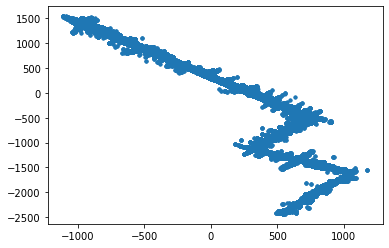

In [19]:
pos = train_agent[:1000000]['centroid']
plt.scatter(pos[:, 0], pos[:, 1], marker='.')
pos

array([[  680.61975098, -2183.32763672],
       [  681.18560791, -2182.42236328],
       [  681.76470947, -2181.52270508],
       ...,
       [  301.4151001 ,    12.56707001],
       [  300.68365479,    13.38139534],
       [  299.93527222,    14.18481255]])

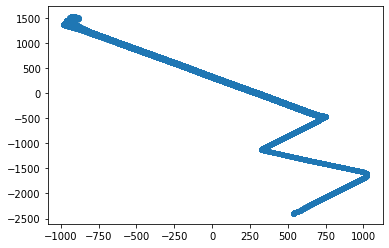

In [20]:
coords = train_frames["ego_translation"][:100000, :2]

plt.scatter(coords[:, 0], coords[:, 1], marker='.')
axes = plt.gca()


#大概能被这样探索

coords



In [93]:
semantic_rasterizer = build_rasterizer(cfg, dm)
semantic_dataset = EgoDataset(cfg, zarr_dataset, semantic_rasterizer)

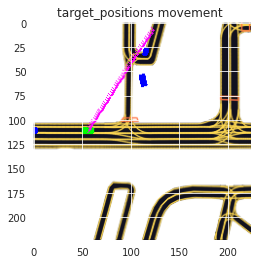

In [94]:

def visualize_trajectory(dataset,index,title="target_positions movement "):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, yaws=data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

visualize_trajectory(semantic_dataset, index=0)

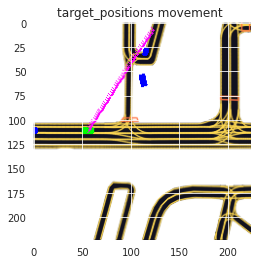

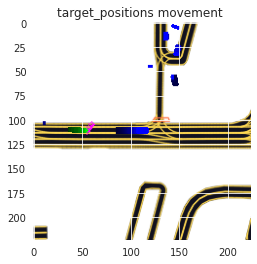

In [95]:
cfg["raster_params"]["map_type"] = "py_satellite"
satellite_rasterizer = build_rasterizer(cfg, dm)
satellite_dataset = EgoDataset(cfg, zarr_dataset, semantic_rasterizer)
type(satellite_rasterizer), type(semantic_rasterizer)
visualize_trajectory(satellite_dataset, index=0)
agent_dataset = AgentDataset(cfg, zarr_dataset, semantic_rasterizer)
visualize_trajectory(agent_dataset, index=0)



In [96]:
from IPython.display import display, clear_output
import PIL

from PIL import Image

dataset = semantic_dataset
scene_idx=10
indexes = dataset.get_scene_indices(scene_idx)
images = []
indexes

for idx in indexes:
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    im=Image.fromarray(im) # numpy 转 image类
    im.show()




    break


    





In [97]:
from IPython.display import display, clear_output
import PIL

dataset = semantic_dataset
scene_idx = 34
indexes = dataset.get_scene_indices(scene_idx)
images = []

for idx in indexes:
    data = dataset[idx]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]

    draw_trajectory(im, target_positions_pixels, yaws=data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)
    clear_output(wait=True)
    images.append(PIL.Image.fromarray(im[::-1]))


(eog:2073135): Gtk-WARNING **: 10:56:22.159: cannot open display: 


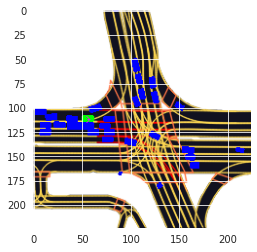

In [98]:
#每一帧数的内容;
# %%capture
# # From https://www.kaggle.com/jpbremer/lyft-scene-visualisations by @jpbremer
def animate_solution(images):

    def animate(i):
        im.set_data(images[i])
        return (im,)

    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    def init():
        im.set_data(images[0])
        return (im,)

    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(images), interval=60, blit=True)

anim = animate_solution(images)

In [84]:
# HTML(anim.to_jshtml())